# Trabalho prático 2 - Implementac¸ao do Algoritmo de Boosting
Aluno: Daniel Ferreira Abadi<br>
Matrícula: 2018088062

O objetivo deste trabalho prática é ganhar experiência com o processo de Boosting visto em sala de aula. Para isso foi nos passada a tarefa de implementar o processo de Boosting como visto em sala, assumindo um problema de classificação binária de resultados do "jogo da velha" com atributos categóricos.

Abaixo temos todas as importações necessárias para a realização do trabalho, além da importação dos dados utilizados, que consideram que os dados estão na mesma pasta onde se encontra este arquivo.

In [ ]:
import pandas as pd
import numpy as np

from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

data = pd.read_csv('tic-tac-toe.data', header=None, delimiter=',')
data.head()

,0,1,2,3,4,5,6,7,8,9
0,x,x,x,x,o,o,x,o,o,positive
1,x,x,x,x,o,o,o,x,o,positive
2,x,x,x,x,o,o,o,o,x,positive
3,x,x,x,x,o,o,o,b,b,positive
4,x,x,x,x,o,o,b,o,b,positive


A função abaixo serve apenas para exibir alguns resultados obtidos com a variação do número de stumps.

In [ ]:
# Função de plot
def plot_charts(x_axis, y_axis, x_label, y_label, title, lim_inf, lim_sup, erro = False):
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.set_title(title)
    ax.set_ylim([lim_inf, lim_sup])
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    if erro:
        colors = ["green" if y ==  min(y_axis) else "gray" for y in y_axis]
    else:
        colors = ["green" if y ==  max(y_axis) else "gray" for y in y_axis]
    ax.bar(x_axis, y_axis, color=colors)
    ax.grid(True, axis='y', color="gray")
    plt.plot()

## Tratamento dos dados

Para facilitar o manuseio e as contas envolvidas na classificação, os símbolos alfabéticos foram todos trocados para apenas números. Os símbolos foram trocados da seguinte maneira:<br>
- 'o' → 0
- 'x' → 1
- 'b' → 2
- 'positive' → +1
- 'negative' → -1<br>

Os símbolos 'positive' e 'negative' foram escolhidos de forma que pudéssemos aplicar as operações matemáticas diretamente nos dados, multiplicando o resultado de saída de cada stump, que seria +1 ou -1, diretamente pelo valor associado ao y.


In [ ]:
def convert_to_numbers(symbol):
    if symbol == 'x' or symbol == 'positive': return 1
    elif symbol == 'o': return 0
    elif symbol == 'b': return 2
    return -1 #negative case

data_numbers = data.applymap(lambda x: convert_to_numbers(x))

Abaixo temos a divisão do conjunto de dados em X e y, tanto para treino quanto para teste, onde o conjunto de dados de treino corresponde a 70% do montante inicial. Os dados foram convertidos para vetores numpy por questões de performance.


In [ ]:
X = data_numbers.loc[:,:8].to_numpy()
y = data_numbers.loc[:,9].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.3)

## Classificador

Para que pudéssemos utilizar o método GridSearchCV para realizar as mudanças de parâmetros e a validação cruzada com 5 partições, foi necessário criar uma classe que contém algumas funções específicas. Inicialmente é necessário fazer com que nossa classe herde a classe BaseEstimator, do SciKit, os métodos de treinamento e teste devem chamar fit e predict, respectivamente, para que possam ser utilizados junto ao GridSearchCV. Outro ponto importante é a criação do método "get_params", que apenas retorna os parâmetros do classificador criado.

A classe criada deve receber como parâmetro apenas o número de stumps que serão utilizados, que é o mesmo número de iterações que serão feitas no conjunto de treino. Ao ser instanciada, é chamado o método "create_stumps", que cria 56 stumps, que possuem a seguinte forma [_, _, _] onde:
- A primeira posição é um inteiro entre 0 e 8, sendo a posição da janela do #. 
-A segunda posição pode conter os números 0, 1 ou 2, correspondentes a 'o', 'x' e 'b'. 
-E a terceira posição contém +1 ou -1, 'positive' e 'negative', respectivamente.<br>

Ao todo são, portanto, 9x3x2 stumps, que foram feitos dessa maneira para facilitar a checagem das posições, símbolos e resultados. Há, também, dois stumps adicionais, que possuem o primeiro valor igual a -1, onde retornam +1 ou -1 para todos os casos.

O método principal de toda a classe é o método "fit", que recebe o X e o y de treino. Ao ser chamada, essa função inicializa os pesos iniciais, todos sendo 1/(tamanho do conjunto X), assim como na teoria. Então, para cada stump, é avaliado seu erro utilizando todo o conjunto de dados, que é calculado de forma empírica. Para cada partida do conjunto de teste, é verificado se o símbolo do stump na posição especificada é o mesmo do jogo, caso o seja é então retornado o terceiro campo do stump, caso não seja é retornado o terceiro campo multiplicado por -1. O cálculo do erro é bem simples, caso uma partida seja classificada erroneamente , o seu peso associado é adicionado a uma variável que acumula os erros. 

Cada stump terá seu próprio erro, e a que obtiver o menor erro será escolhida e o alpha será computado. Tendo o alpha e o stump, podemos então atualizar os pesos. Para isso, cada partida é classificada pelo stump em questão e é realizada a operação de atualização. Para o normalizador Z, foi escolhida simplesmente a soma do novo conjunto de pesos, onde cada peso do vetor é dividido pela soma dos pesos anteriormente atualizados.

In [ ]:
class Boost(BaseEstimator):
    def __init__(self, num_estimators = 100):
        self.num_estimators = num_estimators
        self.create_stumps()

    def get_params(self, deep=True):
        return {'num_estimators': self.num_estimators}

    def init_weights(self, num_weights):
        weights = []
        for i in range(num_weights):
            weights.append(1/num_weights)
        return weights

    def create_stumps(self):
        self.stumps = []
        for i in range(9): # number of positions
            for j in (0, 1, 2): # o, x or b
                for k in (1, -1): # positive or negative
                    self.stumps.append([i, j, k])
        self.stumps.append([-1, '-', 1]) # all positive
        self.stumps.append([-1, '-', -1]) # all negative

    def classify_game(self, stump, game):
        if(stump[0] == -1): 
            return stump[2]
        elif(game[stump[0]] == stump[1]): 
            return stump[2]
        return -stump[2]

    def calcula_erro(self, stump, X_train, y_train):
        erro = 0
        for i in range(len(X_train)):
            ht = self.classify_game(stump, X_train[i])
            if y_train[i] != ht: 
                erro += self.weights[i]
        return erro

    def atualiza_pesos(self, alpha, stump, X_train, y_train):
        for i in range(len(X_train)):
            ht = self.classify_game(stump, X_train[i])
            self.weights[i] = self.weights[i] * np.exp(-alpha * ht * y_train[i])
    
        z = np.sum(self.weights)
        for i in range(len(self.weights)):
            self.weights[i] = self.weights[i] / z

    def predict(self, X_test):
        results = []
        for i in range(len(X_test)):
            classificacao = 0
            for j in range(len(self.chosen_stumps)):
                classificacao += self.alphas[j] * self.classify_game(self.chosen_stumps[j], X_test[i])
            if classificacao > 0: results.append(1)
            else: results.append(-1)
        return results

    def fit(self, X_train, y_train):
        self.weights = self.init_weights(len(X_train))
        self.chosen_stumps = []
        self.alphas = []

        while(self.num_estimators > 0):
            melhor_erro = np.inf
            melhor_stump = []
            for i in range(len(self.stumps)):
                erro = self.calcula_erro(self.stumps[i], X_train, y_train)
                if(erro < melhor_erro):
                    melhor_erro = erro
                    melhor_stump = self.stumps[i]

            alpha = 1/2 * np.log2((1.0-melhor_erro)/melhor_erro)
            self.alphas.append(alpha)
            self.chosen_stumps.append(melhor_stump)
            self.atualiza_pesos(alpha, melhor_stump, X_train, y_train)
            self.num_estimators -= 1

Com todos os preparos concluídos para poder utilizar o método GridSearchCV, o utilizamos passando o único hiperparâmetro criado, o número de estimadores (stumps), a função 'scoring' como a acurácia e o resto padrão, sendo um deles a validação cruzada com 5 folders. Agora temos acesso a algumas facilidades do GridSearchCV, que serão utilizadas para avaliar o modelo e exibir alguns detalhes.

In [ ]:
estimators = np.arange(start=0, stop=151, step=5)
estimators[0] = 1
params = {'num_estimators': estimators}

boost_searcher = GridSearchCV(Boost(), param_grid=params, scoring='accuracy', verbose=1)
boost_searcher.fit(X_train, y_train)

Fitting 5 folds for each of 31 candidates, totalling 155 fits


GridSearchCV(estimator=Boost(),
             param_grid={'num_estimators': array([  1,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,
        65,  70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125,
       130, 135, 140, 145, 150])},
             scoring='accuracy', verbose=1)

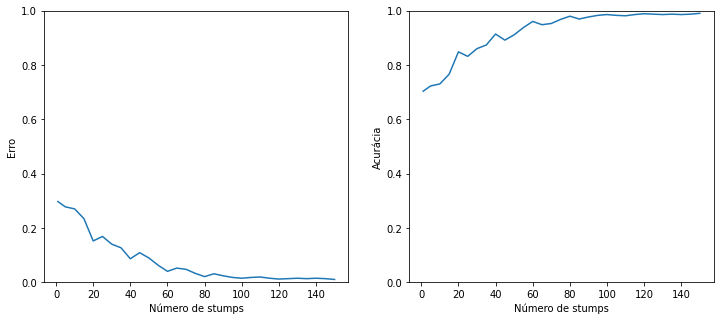

In [ ]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))

ax1.plot(estimators, 1 - boost_searcher.cv_results_["mean_test_score"])
ax1.set_xlabel('Número de stumps')
ax1.set_ylabel('Erro')
ax1.set_ylim(0, 1)

ax2.plot(estimators, boost_searcher.cv_results_["mean_test_score"])
ax2.set_xlabel('Número de stumps')
ax2.set_ylabel('Acurácia')
ax2.set_ylim(0, 1)
plt.show()

Resultados:
Menor erro = 0.010447761194029903
Melhor parâmetro = num_estimators: 150



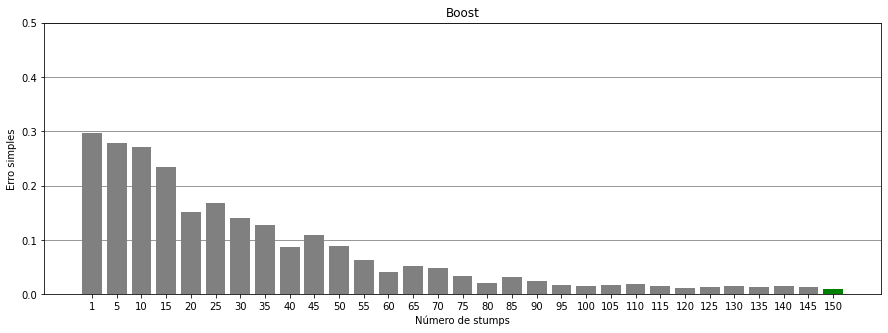

In [ ]:
print(f"Resultados:")
print(f"Menor erro = {1-boost_searcher.best_score_}")
print(f"Melhor parâmetro = {', '.join('{}: {}'.format(k, v) for k, v in boost_searcher.best_params_.items())}\n")
plot_charts([str(x) for x in estimators], 1-boost_searcher.cv_results_["mean_test_score"], 'Número de stumps', 'Erro simples', 'Boost', 0, 0.5, True)

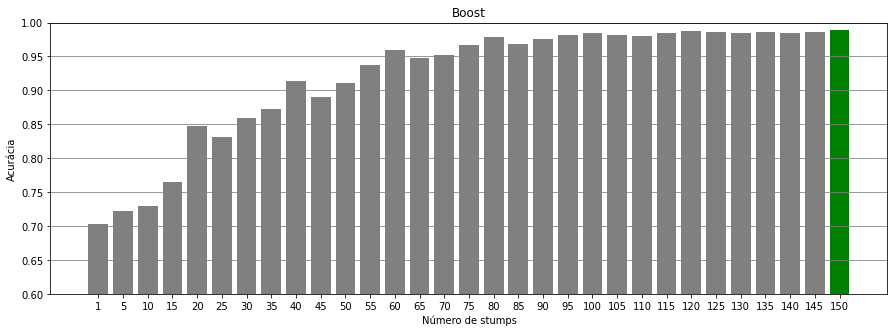

In [ ]:
plot_charts([str(x) for x in estimators], boost_searcher.cv_results_["mean_test_score"], 'Número de stumps', 'Acurácia', 'Boost', 0.6, 1)

Como podemos ver nos gráficos acima, o erro simples, mesmo que dando alguma variada localmente, tende a diminuir conforme aumentamos o número de stumps utilizados, chegando no menor valor com 150 stumps.

In [ ]:
print(f"Erro no conjunto de testes: {1-boost_searcher.score(X_test, y_test)}.")

Erro no conjunto de testes: 0.02777777777777779.


## Conclusão

Foi implementado um algoritmo de Boosting seguindo os conceitos ensinados nas aulas. O problema abordado consiste em classificar corretamente os resultados de partidas do "jogo da velha" e, para isso, foi desenvolvido um classificador baseado em Boosting com seus próprios stumps. Podemos observar pelos gráficos e pelo erro do teste que a implementação foi um sucesso, chegando a valores satisfatórios de erro com o aumento do número de stumps, conforme se espera do algoritmo.